In [8]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.8 MB/s eta 0:00:00


In [5]:
import os
from google.colab import userdata

api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [13]:
from langchain_community.llms import Replicate

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={
        "temperature": 0.7,
        "top_k": 5,
        "top_p": 1.0,
        "max_tokens": 512
    }
)

In [14]:
import pandas as pd

# Load file CSV (ganti path jika perlu)
df = pd.read_csv("/content/riset_lulusan_smasmk - Form Responses 1.csv")

# Ambil kolom narasi
text_data = df["6. Ceritakan secara jujur apa yang Anda rasakan setelah lulus sekolah.  "].dropna().astype(str)


In [20]:
# Prompt dasar untuk klasifikasi
def klasifikasi_sentimen(teks):
    prompt = f"""
Tolong analisis sentimen dari teks berikut dan balas hanya dengan salah satu label ini: positif, negatif, atau netral.

Teks:
\"{teks}\"

Jawaban:
"""
    try:
        response = llm.invoke(prompt).strip().lower()
    except Exception as e:
        response = "error"
    return response

# Normalisasi jawaban model
def normalisasi_label(label):
    label = label.strip().lower()
    if "positif" in label:
        return "positif"
    elif "negatif" in label:
        return "negatif"
    elif "netral" in label:
        return "netral"
    else:
        return "netral"


In [21]:
# Proses seluruh teks
results = [normalisasi_label(klasifikasi_sentimen(teks)) for teks in text_data]

# Gabungkan hasil ke DataFrame
df_hasil = pd.DataFrame({
    "Teks": text_data.values,
    "Label": results
})

# Lihat hasil pertama
df_hasil.head(10)


,Teks,Label
0,nganggur banyak pressure,negatif
1,Very happy,positif
2,"takut tidak bisa jadi orang yang berguna, sela...",negatif
3,Saya merasa gabut dan hampa hingga tanggal 11 ...,netral
4,Ga ada uang sama sekali,negatif
5,bingung ga ada tujuan karna sudah tidak ada ya...,negatif
6,Bosan,netral
7,semakin merasa bahwa beranjak ke jenjang yg le...,netral
8,Senang,positif
9,takut bingitss,negatif


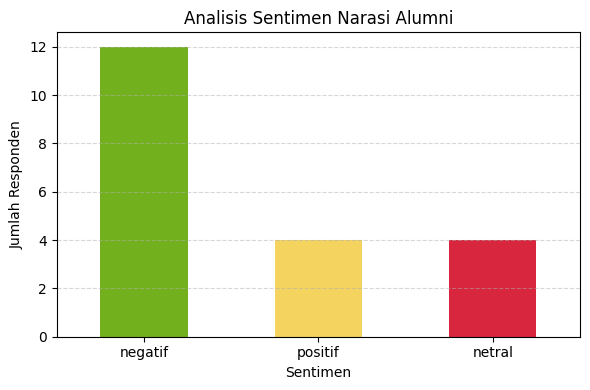

In [34]:
import matplotlib.pyplot as plt

# Hitung jumlah per label (positif, netral, negatif)
label_counts = df_hasil["Label"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['#72B01D', '#F4D35E', '#D7263D'])
plt.title("Analisis Sentimen Narasi Alumni")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Responden")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Jumlah responden per kategori:
Kategori Normal
Kuliah       9
Kerja        6
Lainnya      3
Wirausaha    2
Name: count, dtype: int64


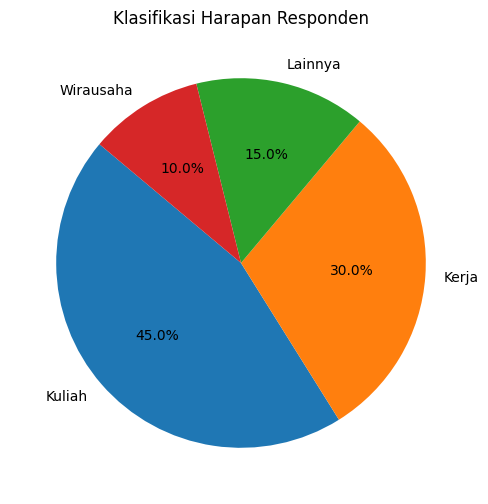

In [32]:
# 1. Import Library
import pandas as pd
import time
import matplotlib.pyplot as plt
from langchain_community.llms import Replicate

# 2. Load Data CSV
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df = pd.read_csv(file_path)

# 3. Ambil kolom 7
kolom7 = df["7. Apa yang anda harapkan untuk diri anda di masa depan?  "].dropna()

# 4. Setup AI Granite 3.3 dari Langchain Replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={
        "top_k": 5,
        "top_p": 1.0,
        "max_tokens": 200,
        "temperature": 0.5
    }
)

# 5. Fungsi klasifikasi AI
def klasifikasi_ai(teks):
    prompt = f"""
    Kategorikan harapan berikut menjadi salah satu dari kategori berikut:
    - Kuliah
    - Kerja
    - Wirausaha
    - Menganggur/Bingung
    - Lainnya

    Harapan: "{teks}"
    Jawaban hanya salah satu dari nama kategori di atas. Jangan beri penjelasan tambahan.
    """
    try:
        return llm.invoke(prompt).strip()
    except Exception as e:
        return "Lainnya"

# 6. Proses Semua Baris
hasil_klasifikasi = []
for teks in kolom7:
    hasil = klasifikasi_ai(teks)
    hasil_klasifikasi.append(hasil)
    time.sleep(1.5)  # jeda untuk hindari limit API

# 7. Simpan ke DataFrame
df_klasifikasi = pd.DataFrame({
    "Jawaban Responden": kolom7.values,
    "Kategori": hasil_klasifikasi
})

# 8. Normalisasi Kategori (antisipasi variasi label)
def normalisasi_kategori(label):
    label = label.lower().strip()
    if "kuliah" in label:
        return "Kuliah"
    elif "kerja" in label:
        return "Kerja"
    elif "usaha" in label or "wira" in label:
        return "Wirausaha"
    elif "bingung" in label or "nganggur" in label:
        return "Menganggur/Bingung"
    else:
        return "Lainnya"

df_klasifikasi["Kategori Normal"] = df_klasifikasi["Kategori"].apply(normalisasi_kategori)

# 9. Tampilkan hasil klasifikasi
print("Jumlah responden per kategori:")
print(df_klasifikasi["Kategori Normal"].value_counts())

# 10. Visualisasi Pie Chart
df_klasifikasi["Kategori Normal"].value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(8, 6),
    startangle=140,
    ylabel="",
    title="Klasifikasi Harapan Responden"
)
plt.show()


Jumlah responden per kategori (kolom 8):
Kategori Normal
Melanjutkan Kuliah            6
Memulai Usaha                 5
Mencari atau Memulai Kerja    4
Masih Bingung / Lainnya       3
Mengembangkan Diri / Skill    2
Name: count, dtype: int64


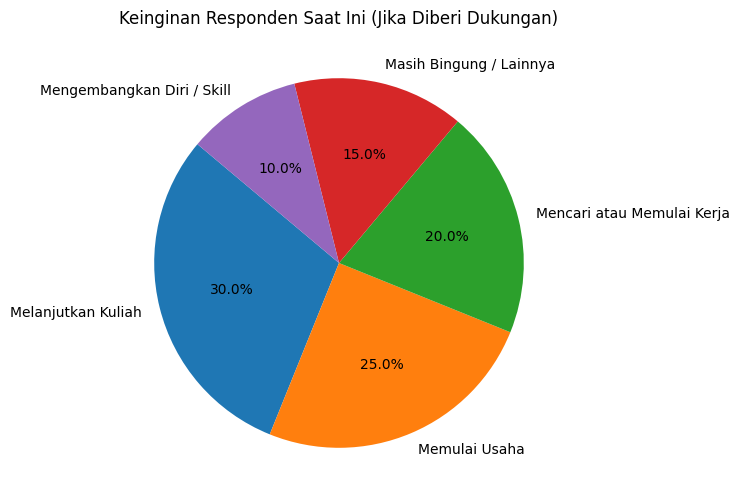

In [31]:
# 1. Ambil kolom 8
kolom8 = df["8. Jika diberi kesempatan dan dukungan, apa yang paling ingin Anda lakukan saat ini?  "].dropna()

# 2. Fungsi klasifikasi AI untuk kolom 8
def klasifikasi_ai_kolom8(teks):
    prompt = f"""
    Kategorikan jawaban berikut ke dalam salah satu dari kategori ini:
    - Melanjutkan Kuliah
    - Mencari atau Memulai Kerja
    - Memulai Usaha
    - Mengembangkan Diri / Skill
    - Masih Bingung / Lainnya

    Jawaban: "{teks}"
    Berikan hanya salah satu dari nama kategori tersebut, tanpa penjelasan tambahan.
    """
    try:
        return llm.invoke(prompt).strip()
    except:
        return "Masih Bingung / Lainnya"

# 3. Proses AI klasifikasi kolom 8
hasil_klasifikasi8 = []
for teks in kolom8:
    hasil = klasifikasi_ai_kolom8(teks)
    hasil_klasifikasi8.append(hasil)
    time.sleep(1.5)

# 4. Buat DataFrame klasifikasi kolom 8
df_klasifikasi8 = pd.DataFrame({
    "Jawaban Responden": kolom8.values,
    "Kategori": hasil_klasifikasi8
})

# 5. Normalisasi label hasil klasifikasi
def normalisasi_kategori8(label):
    label = label.lower()
    if "kuliah" in label:
        return "Melanjutkan Kuliah"
    elif "kerja" in label:
        return "Mencari atau Memulai Kerja"
    elif "usaha" in label or "jualan" in label or "bisnis" in label:
        return "Memulai Usaha"
    elif "belajar" in label or "skill" in label or "kursus" in label:
        return "Mengembangkan Diri / Skill"
    else:
        return "Masih Bingung / Lainnya"

df_klasifikasi8["Kategori Normal"] = df_klasifikasi8["Kategori"].apply(normalisasi_kategori8)

# 6. Tampilkan hasil dan Pie Chart
print("Jumlah responden per kategori (kolom 8):")
print(df_klasifikasi8["Kategori Normal"].value_counts())

df_klasifikasi8["Kategori Normal"].value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(8, 6),
    startangle=140,
    ylabel="",
    title="Keinginan Responden Saat Ini (Jika Diberi Dukungan)"
)
plt.show()


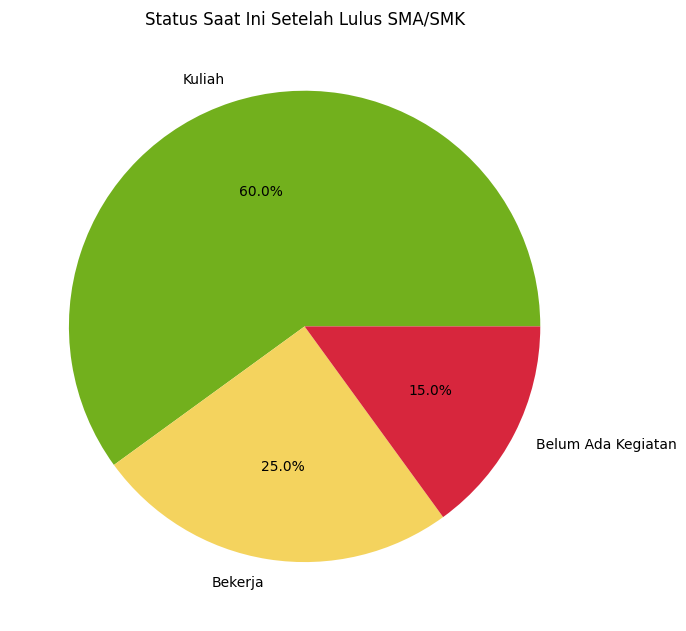

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load ulang file (jika belum)
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df = pd.read_csv(file_path)

# 2. Ambil kolom 1 (ubah sesuai nama persis kolomnya)
kolom1 = df["1. Setelah lulus, saat ini Anda sedang:  "].dropna()

# 3. Normalisasi jawaban (jika perlu, bisa kamu sesuaikan lebih detail nanti)
def normalisasi_status(status):
    status = status.lower().strip()
    if "kuliah" in status:
        return "Kuliah"
    elif "kerja" in status or "bekerja" in status:
        return "Bekerja"
    elif "usaha" in status or "wira" in status:
        return "Wirausaha"
    elif "belum" in status or "nganggur" in status:
        return "Belum Ada Kegiatan"
    else:
        return "Lainnya"

kolom1_normal = kolom1.apply(normalisasi_status)

# 4. Hitung jumlah per kategori
status_counts = kolom1_normal.value_counts()

# 5. Pie chart visualisasi
plt.figure(figsize=(7, 7))
colors = ["#72B01D", "#F4D35E", "#D7263D", "#7C7C7C", "#8AAAE5"]
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=colors)
plt.title("Status Saat Ini Setelah Lulus SMA/SMK")
plt.tight_layout()
plt.show()


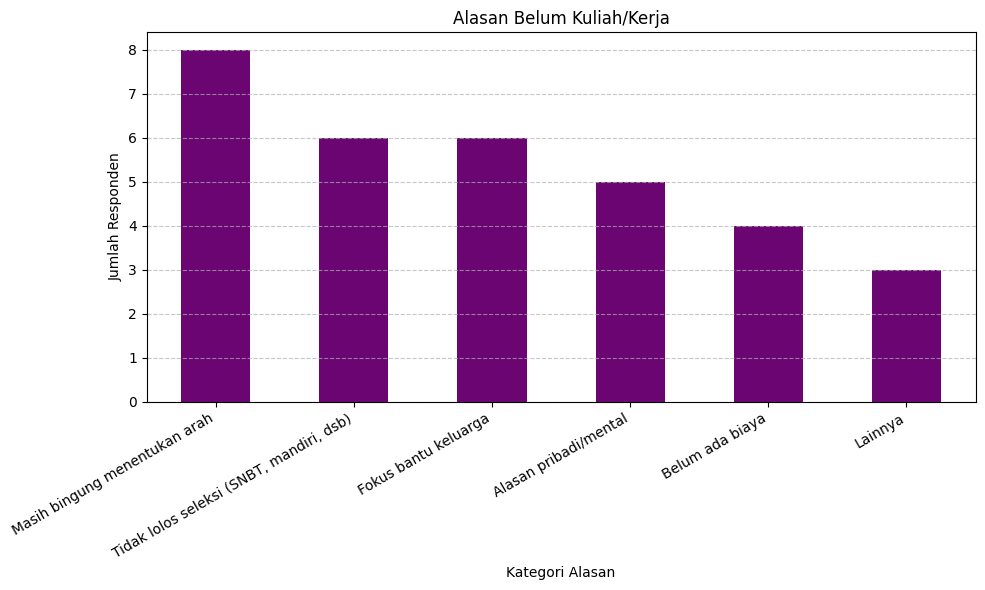

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca data
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df = pd.read_csv(file_path)

# 2. Ambil jawaban no 2 & hapus NaN
kolom2 = df["2. Jika Anda belum kuliah/kerja, apa alasannya?"].dropna()

# 3. Pecah jawaban multi-alasan
alasan_list = []
for jawaban in kolom2:
    alasan_terpisah = [a.strip().lower() for a in jawaban.split(',')]
    alasan_list.extend(alasan_terpisah)

# 4. Mapping ke 5 kategori resmi
def kategorikan(a):
    a = a.lower()
    if "biaya" in a:
        return "Belum ada biaya"
    elif "tidak lolos" in a or "tidak lulus" in a or "gagal" in a or "snbt" in a or "mandiri" in a:
        return "Tidak lolos seleksi (SNBT, mandiri, dsb)"
    elif "bingung" in a or "belum tahu" in a or "belum tau" in a or "arah" in a:
        return "Masih bingung menentukan arah"
    elif "keluarga" in a or "bantu" in a:
        return "Fokus bantu keluarga"
    elif "mental" in a or "minder" in a or "pribadi" in a:
        return "Alasan pribadi/mental"
    else:
        return "Lainnya"

alasan_kategori = [kategorikan(a) for a in alasan_list]

# 5. Hitung jumlah kategori
df_alasan = pd.DataFrame(alasan_kategori, columns=["Kategori"])
alasan_counts = df_alasan["Kategori"].value_counts()

# 6. Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
alasan_counts.plot(kind='bar', color="#6A0572")
plt.title("Alasan Belum Kuliah/Kerja")
plt.xlabel("Kategori Alasan")
plt.ylabel("Jumlah Responden")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Distribusi Skor Kecemasan:
 3. Apakah Anda merasa tertekan atau cemas tentang masa depan Anda?\n1 = Tidak sama sekali\n5 = Sangat cemas
1    4
2    2
3    7
4    4
5    3
Name: count, dtype: int64


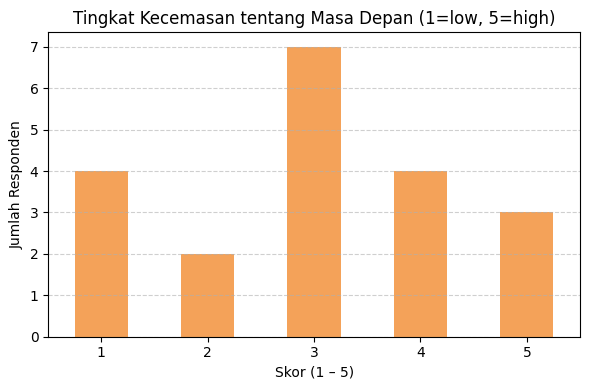

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca data
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df        = pd.read_csv(file_path)

# 2. Ambil kolom skala 1‑5 (gunakan filter agar tak masalah spasi/new‑line)
col3 = df.filter(like="Apakah Anda merasa tertekan").iloc[:,0].dropna()

# 3. Konversi ke integer (jaga‑jaga jika tersimpan sebagai string)
col3 = col3.astype(int)

# 4. Hitung frekuensi tiap skala
freq = col3.value_counts().sort_index()   # urut 1→5

print("Distribusi Skor Kecemasan:\n", freq)

# 5. Bar Chart
plt.figure(figsize=(6,4))
freq.plot(kind="bar", color="#F4A259")
plt.title("Tingkat Kecemasan tentang Masa Depan (1=low, 5=high)")
plt.xlabel("Skor (1 – 5)")
plt.ylabel("Jumlah Responden")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Distribusi Skor Rasa Minder:
  4. Seberapa sering Anda merasa minder saat melihat teman yang sudah kuliah atau kerja?\n1 = Tidak pernah\n5 = Sangat sering\n  
1    5
2    5
3    4
4    1
5    5
Name: count, dtype: int64


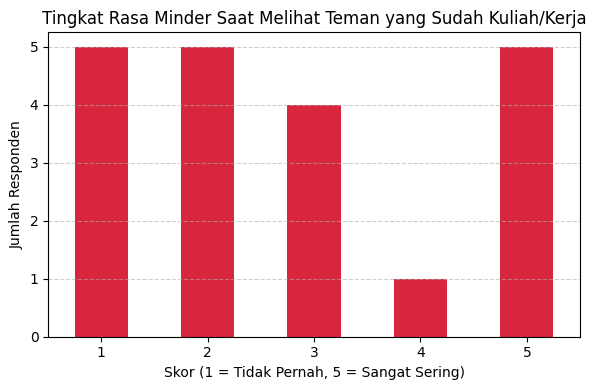

Rata-rata rasa minder: 2.8


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca data
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df = pd.read_csv(file_path)

# 2. Ambil kolom no.4 (pakai filter agar aman dari variasi teks)
col4 = df.filter(like="Seberapa sering Anda merasa minder").iloc[:,0].dropna()

# 3. Konversi ke integer
col4 = col4.astype(int)

# 4. Hitung distribusi frekuensi
freq = col4.value_counts().sort_index()

print("Distribusi Skor Rasa Minder:\n", freq)

# 5. Bar Chart Visualisasi
plt.figure(figsize=(6, 4))
freq.plot(kind="bar", color="#D7263D")
plt.title("Tingkat Rasa Minder Saat Melihat Teman yang Sudah Kuliah/Kerja")
plt.xlabel("Skor (1 = Tidak Pernah, 5 = Sangat Sering)")
plt.ylabel("Jumlah Responden")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Rata-rata rasa minder:", col4.mean())



Distribusi Dukungan Emosional:
 5. Apakah Anda merasa memiliki dukungan emosional dari keluarga atau teman?  
Ada, tapi kurang intens    10
Ya, sangat mendukung        9
Tidak ada sama sekali       1
Name: count, dtype: int64


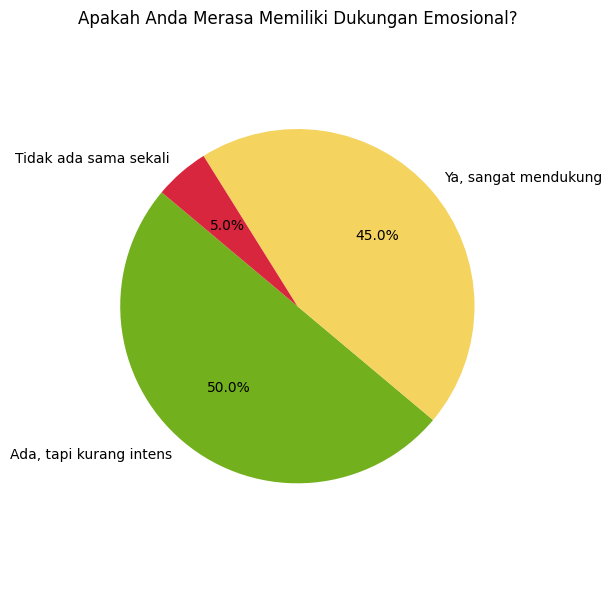

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data
file_path = "/content/riset_lulusan_smasmk - Form Responses 1.csv"
df = pd.read_csv(file_path)

# 2. Ambil kolom no.5 (pakai filter agar lebih aman dari perubahan format)
col5 = df.filter(like="dukungan emosional").iloc[:, 0].dropna()

# 3. Hitung frekuensi tiap jawaban
freq = col5.value_counts()

print("Distribusi Dukungan Emosional:\n", freq)

# 4. Visualisasi - Pie Chart
colors = ["#72B01D", "#F4D35E", "#D7263D"]  # Hijau = positif, Kuning = netral, Merah = negatif
plt.figure(figsize=(6, 6))
plt.pie(freq, labels=freq.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Apakah Anda Merasa Memiliki Dukungan Emosional?")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [48]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [49]:
output_path = "/content/drive/MyDrive/hasil_klasifikasi.csv"
df_klasifikasi.to_csv(output_path, index=False)


In [50]:
plt.savefig("/content/drive/MyDrive/chart_klasifikasi.png")


<Figure size 640x480 with 0 Axes>

In [51]:
from google.colab import files
df_klasifikasi.to_csv("hasil_klasifikasi.csv", index=False)
files.download("hasil_klasifikasi.csv")

plt.savefig("chart_klasifikasi.png")
files.download("chart_klasifikasi.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>